<a href="https://colab.research.google.com/github/bkrfethi/DataScience-estin-Labs/blob/main/FDS_Lab4_TimeSeries_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Lab 4: Time Series Analysis Pipeline
**Dataset:** Daily Delhi Climate Data | **Goal:** Predict Next-Day Temperature

---

### 🎯 Lab Objectives
1.  **Preprocessing:** Date conversion, Frequency analysis, Handling missing timestamps.
2.  **Visualization:** Decomposing Trend, Seasonality, and Noise.
3.  **Feature Engineering:** Lags, Rolling Windows (SMA/EMA), Cyclic Encoding.
4.  **Stationarity:** ADF Test, Differencing, ACF plots.
5.  **Resampling:** Downsampling (Weekly) & Upsampling (Hourly).

---

In [1]:
!pip install tsfresh statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series

# Visual config
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Libraries installed and imported.")

Libraries installed and imported.


In [2]:
# --- DATA LOADING ---
try:
    df = pd.read_csv('DailyDelhiClimateTrain.csv')
    print("Dataset loaded from CSV.")
except FileNotFoundError:
    print(" CSV not found. Generating dummy data for demonstration...")
    dates = pd.date_range(start='2013-01-01', end='2017-01-01', freq='D')
    temp = 25 + 10 * np.sin(2 * np.pi * dates.dayofyear / 365) + np.random.normal(0, 2, len(dates))
    df = pd.DataFrame({'date': dates, 'meantemp': temp})
    df = df.sample(frac=0.98).sort_values('date')

# --- 1. CONVERT DATE ---
df.columns = df.columns.str.lower().str.strip()
if 'date' not in df.columns:
    # Try to find the date column
    date_col = [c for c in df.columns if 'date' in c][0]
    df.rename(columns={date_col: 'date'}, inplace=True)

df['date'] = pd.to_datetime(df['date'])
print("\n--- 1. First 5 Converted Rows ---")
display(df.head())

# --- 2. IDENTIFY FREQUENCY ---
df = df.sort_values('date')
time_diffs = df['date'].diff().dropna()
print("\n--- 2. Frequency Analysis ---")
print(f"Most common time difference: {time_diffs.mode()[0]}")
print("Is the frequency naturally daily?", "Yes" if time_diffs.mode()[0] == pd.Timedelta(days=1) else "No")

# --- 3. CHECK EXPECTED TIMESTAMPS ---
start_date = df['date'].min()
end_date = df['date'].max()
expected_range = pd.date_range(start=start_date, end=end_date, freq='D')
missing_dates = expected_range.difference(df['date'])

print("\n--- 3. Missing Dates ---")
if len(missing_dates) > 0:
    print(f"Found {len(missing_dates)} missing days.")
    print(f"First 5 missing: {missing_dates[:5].tolist()}")
    print("Observation: These gaps make the series 'irregular' and break autoregressive models.")
else:
    print("No missing dates found.")

# --- 4. UPSAMPLE & FILL ---
df = df.set_index('date')
df_daily = df.reindex(expected_range)
df_daily.index.name = 'date'


df_daily['meantemp'] = df_daily['meantemp'].interpolate(method='linear')

print("\n--- 4. Data Upsampled and Filled ---")
print(f"New shape: {df_daily.shape}")
print(f"Remaining NaNs: {df_daily['meantemp'].isna().sum()}")

Dataset loaded from CSV.

--- 1. First 5 Converted Rows ---


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000



--- 2. Frequency Analysis ---
Most common time difference: 1 days 00:00:00
Is the frequency naturally daily? Yes

--- 3. Missing Dates ---
No missing dates found.

--- 4. Data Upsampled and Filled ---
New shape: (1462, 4)
Remaining NaNs: 0


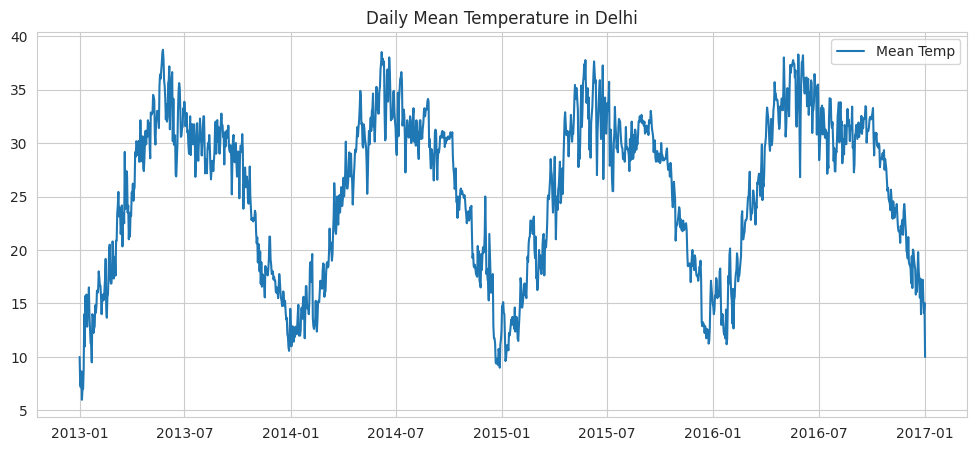

Comment: We see clear yearly Seasonality (peaks in summer, valleys in winter). Noise seems constant.


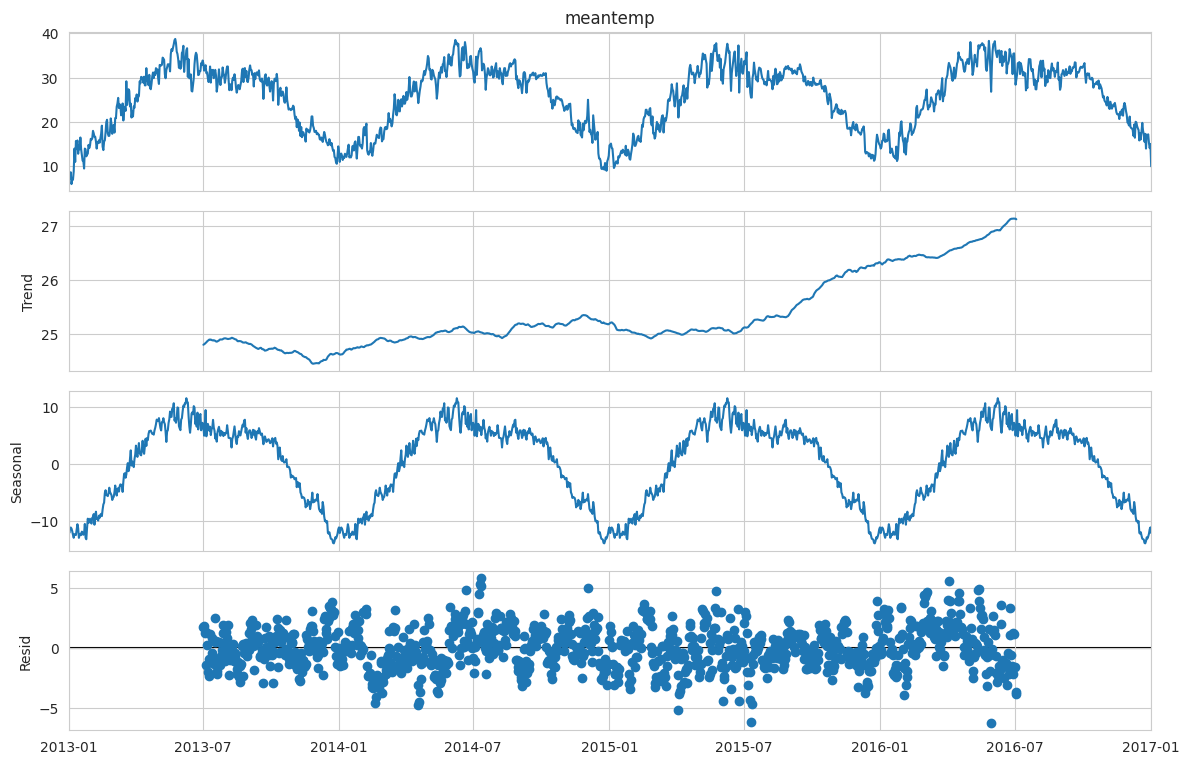

Trend: Shows if Delhi is getting hotter over years.
Seasonality: Very strong and regular sinusoidal pattern.

--- 7. Split Shapes ---
Train: (1096, 4), Val: (219, 4), Test: (147, 4)


In [3]:
# --- 5. PLOT SERIES ---
plt.figure(figsize=(12, 5))
plt.plot(df_daily.index, df_daily['meantemp'], label='Mean Temp')
plt.title("Daily Mean Temperature in Delhi")
plt.legend()
plt.show()
print("Comment: We see clear yearly Seasonality (peaks in summer, valleys in winter). Noise seems constant.")

# --- 6. DECOMPOSITION ---
decomposition = seasonal_decompose(df_daily['meantemp'], model='additive', period=365)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()
print("Trend: Shows if Delhi is getting hotter over years.")
print("Seasonality: Very strong and regular sinusoidal pattern.")

# --- 7. SPLIT DATA (75/15/15) ---
n = len(df_daily)
train_end = int(n * 0.75)
val_end = int(n * 0.90)

train = df_daily.iloc[:train_end]
val = df_daily.iloc[train_end:val_end]
test = df_daily.iloc[val_end:]

print(f"\n--- 7. Split Shapes ---\nTrain: {train.shape}, Val: {val.shape}, Test: {test.shape}")

In [6]:
# Working on a copy of the full dataset for feature engineering
df_feat = df_daily.copy()

# --- 8. DATE FEATURES & CYCLIC ENCODING ---
df_feat['day_of_week'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month
df_feat['week_of_year'] = df_feat.index.isocalendar().week.astype(int)
df_feat['day_of_year'] = df_feat.index.dayofyear
df_feat['is_weekend'] = df_feat['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Cyclic Encoding
df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)
df_feat['dow_sin'] = np.sin(2 * np.pi * df_feat['day_of_week'] / 7)
df_feat['dow_cos'] = np.cos(2 * np.pi * df_feat['day_of_week'] / 7)

print("\n--- 8. Cyclic Features Created ---")

# --- 9. AUTOMATED FEATURES (TSFRESH) ---
print("\n--- 9. Generating Automated Features (TSFRESH) ---")

try:
    # Prepare data for tsfresh
    df_ts = pd.DataFrame({'id': 1, 'time': df_feat.index, 'value': df_feat['meantemp']})
    # We will extract features just to show it works (computationally heavy!)
    extracted_features = extract_features(df_ts, column_id='id', column_sort='time',
                                          default_fc_parameters= {'maximum': None, 'minimum': None, 'mean': None})
    print("Extracted basic features via tsfresh:")
    display(extracted_features)
except Exception as e:
    print(f"Skipping tsfresh due to environment limits: {e}")


--- 8. Cyclic Features Created ---

--- 9. Generating Automated Features (TSFRESH) ---


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 434.01it/s]

Extracted basic features via tsfresh:


,value__maximum,value__minimum,value__mean
1,38.714286,6.0,25.495521


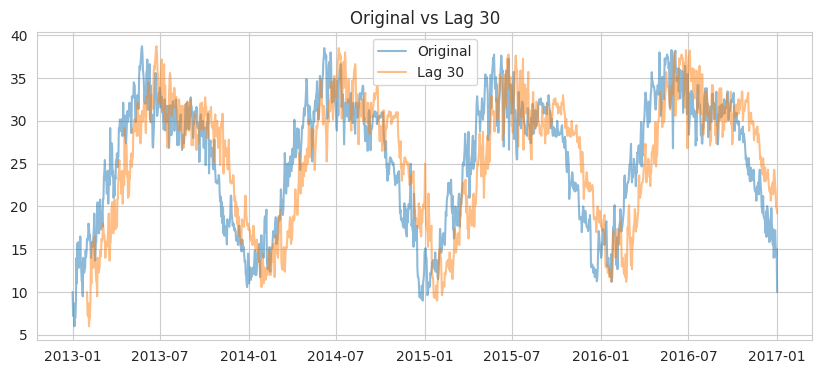

Q: Why NaNs? A: Because there is no historical data for the first N days to shift forward.


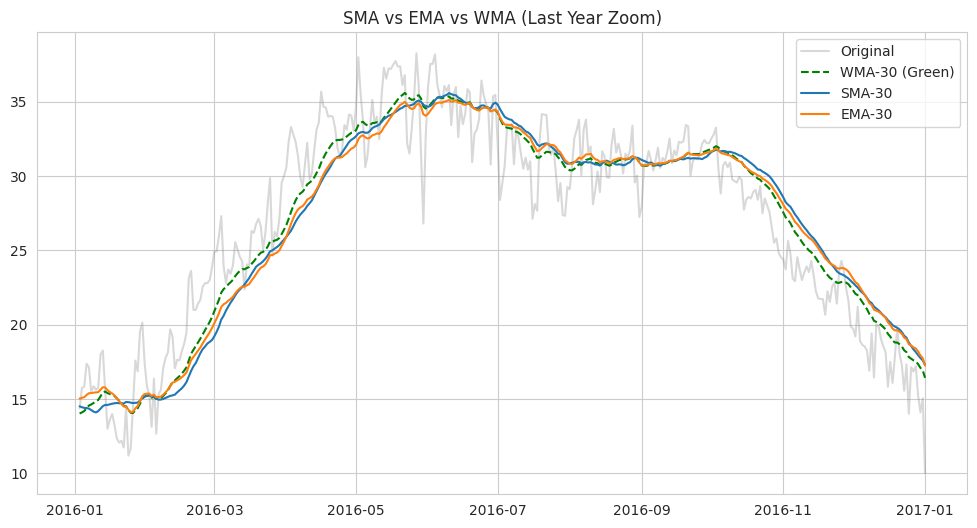

Comparison: EMA reacts fastest because it gives more weight to recent data. SMA is the smoothest but lags behind.


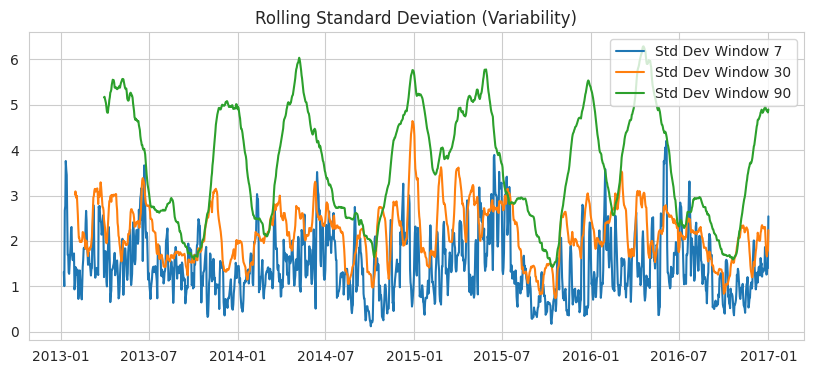

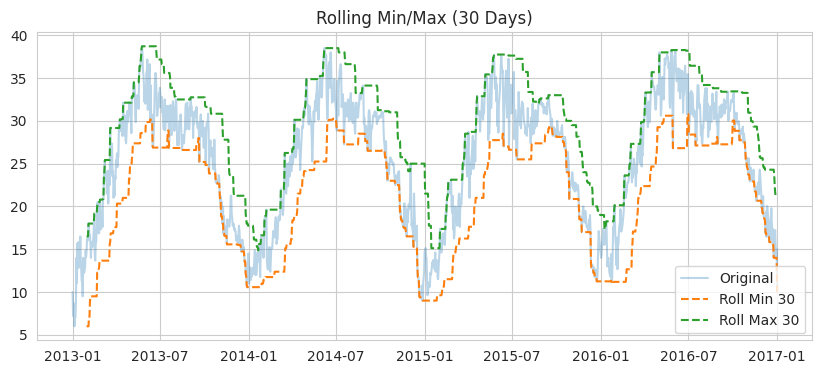

In [8]:
# --- 10. LAGS ---
lags = [7, 30, 90]
for lag in lags:
    df_feat[f'Lag_{lag}'] = df_feat['meantemp'].shift(lag)

# Plotting Lags
plt.figure(figsize=(10, 4))
plt.plot(df_feat.index, df_feat['meantemp'], alpha=0.5, label='Original')
plt.plot(df_feat.index, df_feat['Lag_30'], alpha=0.5, label='Lag 30')
plt.title("Original vs Lag 30")
plt.legend()
plt.show()
print("Q: Why NaNs? A: Because there is no historical data for the first N days to shift forward.")

# --- 11 & 12. SMA, WMA, EMA ---
windows = [7, 30, 90]

# Helper for WMA (Weighted Moving Average)
def wma(x):
    weights = np.arange(1, len(x) + 1)
    return np.dot(x, weights) / weights.sum()

plt.figure(figsize=(12, 6))
plt.plot(df_feat.index[-365:], df_feat['meantemp'].iloc[-365:], label='Original', alpha=0.3, color='gray')

for w in windows:
    # SMA
    sma = df_feat['meantemp'].rolling(window=w).mean()
    # EMA
    ema = df_feat['meantemp'].ewm(span=w, adjust=False).mean()
    # WMA
    if w == 30:
        wma_series = df_feat['meantemp'].rolling(window=w).apply(wma, raw=True)
        plt.plot(df_feat.index[-365:], wma_series.iloc[-365:], label=f'WMA-{w} (Green)', linestyle='--', color='green')

    if w == 30:
        plt.plot(df_feat.index[-365:], sma.iloc[-365:], label=f'SMA-{w}')
        plt.plot(df_feat.index[-365:], ema.iloc[-365:], label=f'EMA-{w}')

plt.title("SMA vs EMA vs WMA (Last Year Zoom)")
plt.legend()
plt.show()
print("Comparison: EMA reacts fastest because it gives more weight to recent data. SMA is the smoothest but lags behind.")

# --- 13. ROLLING STD ---
plt.figure(figsize=(10, 4))
for w in [7, 30, 90]:
    r_std = df_feat['meantemp'].rolling(window=w).std()
    plt.plot(df_feat.index, r_std, label=f'Std Dev Window {w}')
plt.title("Rolling Standard Deviation (Variability)")
plt.legend()
plt.show()

# --- 14. ROLLING MIN/MAX ---
plt.figure(figsize=(10, 4))
plt.plot(df_feat.index, df_feat['meantemp'], alpha=0.3, label='Original')
plt.plot(df_feat.index, df_feat['meantemp'].rolling(30).min(), label='Roll Min 30', linestyle='--')
plt.plot(df_feat.index, df_feat['meantemp'].rolling(30).max(), label='Roll Max 30', linestyle='--')
plt.title("Rolling Min/Max (30 Days)")
plt.legend()
plt.show()



--- 15. Top Features Correlated with Target ---
Target_NextDay    1.000000
meantemp          0.973697
Lag_7             0.908494
month_cos         0.838953
Lag_30            0.751834
humidity          0.536761
wind_speed        0.301467
month_sin         0.247353
Lag_90            0.085342
meanpressure      0.034028
Name: Target_NextDay, dtype: float64

--- Checking Stationarity: Original Data ---
ADF Statistic: -1.6107892332604044
p-value: 0.4775613313251885
 Weak evidence against null hypothesis -> Series is NON-STATIONARY


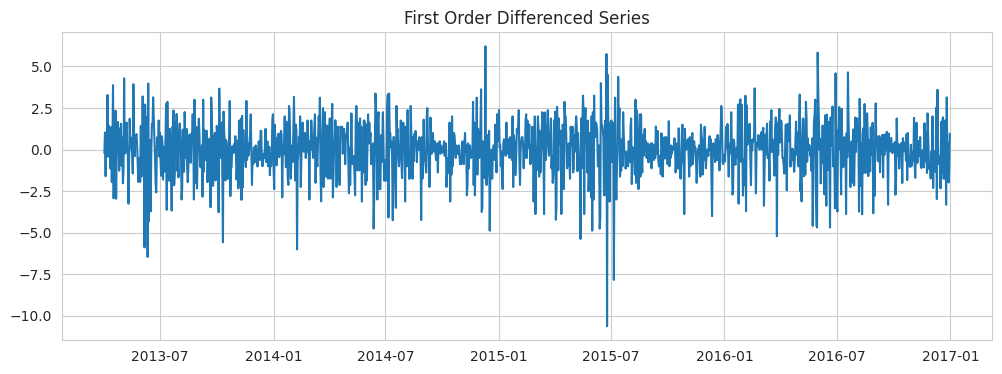


--- Checking Stationarity: Differenced Data ---
ADF Statistic: -16.029997686446478
p-value: 6.072000384848612e-29
Evidence against null hypothesis -> Series is STATIONARY


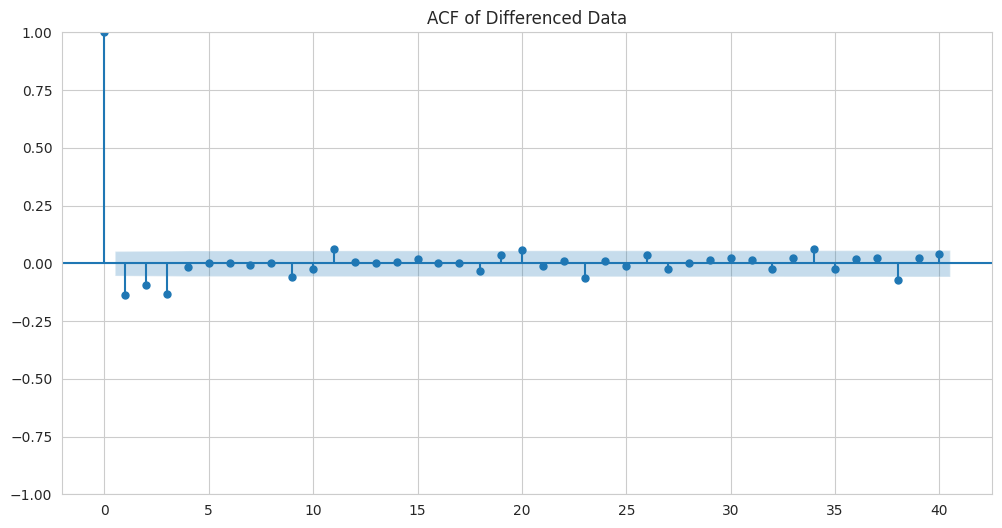


--- 18. Downsampling (Weekly) ---
Original Size: 1462, Weekly Size: 209


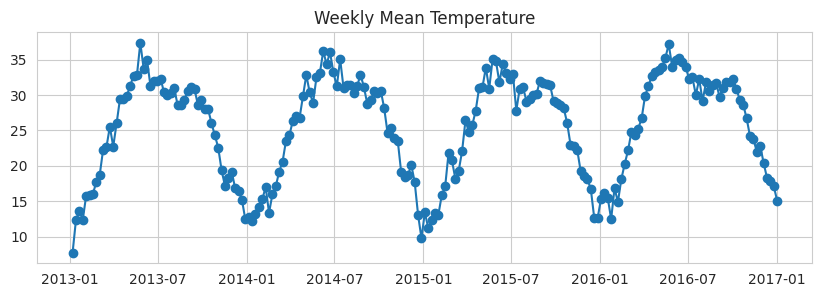

/tmp/ipython-input-333336796.py:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_daily['meantemp'].resample('H').interpolate(method='linear')



--- 19. Upsampling (Hourly) ---
Hourly Size: 35065


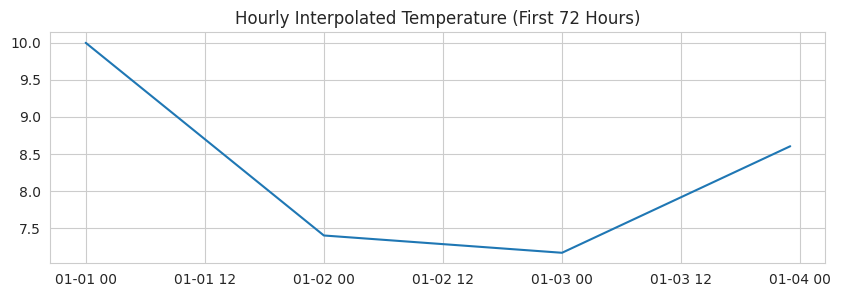


 LAB 4 COMPLETE.


In [9]:
# --- 15. TARGET CREATION & SELECTION ---
df_feat['Target_NextDay'] = df_feat['meantemp'].shift(-1)

# Drop NaNs created by lags and target
df_clean = df_feat.dropna()

# Feature Selection (Correlation)
corr_matrix = df_clean.corr()
target_corr = corr_matrix['Target_NextDay'].abs().sort_values(ascending=False)
print("\n--- 15. Top Features Correlated with Target ---")
print(target_corr.head(10))

# --- 16. STATIONARITY CHECK (ADF) ---
def check_stationarity(timeseries, title="Timeseries"):
    print(f"\n--- Checking Stationarity: {title} ---")
    result = adfuller(timeseries.dropna(), autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Evidence against null hypothesis -> Series is STATIONARY")
    else:
        print(" Weak evidence against null hypothesis -> Series is NON-STATIONARY")

check_stationarity(df_clean['meantemp'], "Original Data")

# --- 17. MAKE STATIONARY (Differencing) ---
df_diff = df_clean['meantemp'].diff().dropna()
df_seasonal_diff = df_clean['meantemp'].diff(365).dropna()

plt.figure(figsize=(12, 4))
plt.plot(df_diff)
plt.title("First Order Differenced Series")
plt.show()

check_stationarity(df_diff, "Differenced Data")
plot_acf(df_diff, lags=40, title="ACF of Differenced Data")
plt.show()

# --- 18 & 19. RESAMPLING ---
df_weekly = df_daily['meantemp'].resample('W').mean()
print(f"\n--- 18. Downsampling (Weekly) ---\nOriginal Size: {len(df_daily)}, Weekly Size: {len(df_weekly)}")
plt.figure(figsize=(10,3))
plt.plot(df_weekly, marker='o')
plt.title("Weekly Mean Temperature")
plt.show()

# Upsample to Hourly
df_hourly = df_daily['meantemp'].resample('H').interpolate(method='linear')
print(f"\n--- 19. Upsampling (Hourly) ---\nHourly Size: {len(df_hourly)}")
plt.figure(figsize=(10,3))
plt.plot(df_hourly.iloc[:72]) # Plot first 3 days
plt.title("Hourly Interpolated Temperature (First 72 Hours)")
plt.show()

print("\n LAB 4 COMPLETE.")